In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import joblib

df = pd.read_csv("../data/heart.csv")  
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
print(df.shape)
print(df.columns)
print(df['target'].value_counts(dropna=False))  
df.isnull().sum()


(1025, 14)
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
target
1    526
0    499
Name: count, dtype: int64


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [4]:
if df['target'].max() > 1:
    df['target'] = df['target'].apply(lambda x: 1 if x>0 else 0)
    print("Converted target to binary.")



In [5]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)



In [6]:
num_features = ['age','trestbps','chol','thalach','oldpeak']
cat_features = [c for c in X.columns if c not in num_features]

for c in cat_features:
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
   ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))

])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

clf_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
])

clf_pipeline.fit(X_train, y_train)


,steps,"[('preproc', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205

ROC AUC: 1.0


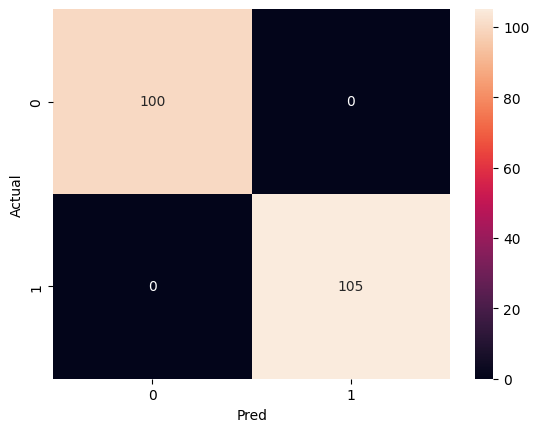

In [7]:
y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d'); plt.xlabel('Pred'); plt.ylabel('Actual'); plt.show()


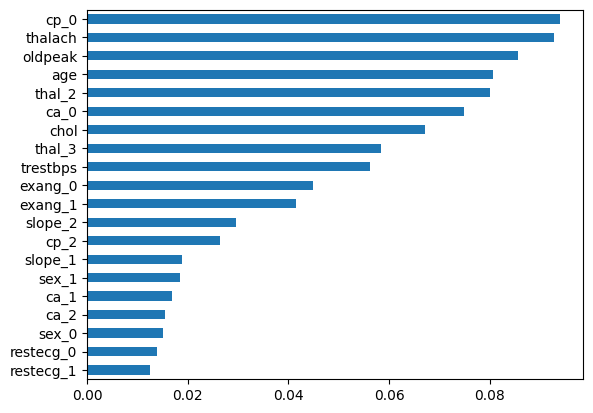

In [8]:
ohe = clf_pipeline.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
ohe_names = ohe.get_feature_names_out(cat_features)
feature_names = np.array(num_features + list(ohe_names))
importances = clf_pipeline.named_steps['rf'].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
fi.plot(kind='barh'); plt.gca().invert_yaxis(); plt.show()


In [9]:
joblib.dump(clf_pipeline, "../models/heart_rf_pipeline.joblib")
print("Saved pipeline to ../models/heart_rf_pipeline.joblib")


Saved pipeline to ../models/heart_rf_pipeline.joblib
